In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import pandas as pd
import sys
import os
sys.path.insert(1, '../../PENTrackAnalysis/')
import ParticlePlottingFunctions as ppf
from matplotlib import cm
from datetime import date
import CoordTransfFunctions as ctf

In [2]:
%load_ext autoreload
%autoreload 2

### For data from the df file
* x,y,z are in cm
* B_i is in G = 0.1 mT $= 10^{-4}$ T

Coordinate center is not know yet, but data was aquired from Takashi's 2019 mapping and processed using:
```
df_all['x'] = - df_all.u + 10.25
df_all['y'] = -df_all.w
df_all['z'] = df_all.v -1.25 +188.1 -275 #-> sets z = 0 to the center of the MSR 
# -1.25cm accounts for the position of the sensing center of the probe and the marker on the probe. 
# + 188.1cm: from z=0 of the measurement to the floor, -275cm: from the floor to the planned center of MSR

df_all['B_x'] = -df_all['B_u']
df_all['B_y'] = -df_all['B_w']
df_all['B_z'] = -df_all['B_v'] 
```
z = 0 is at what ever the planed center of the MSR was at the time   
* The distance from the center of the MSR (I think - I am using this as the center of the central electrode) to the floor is now 258.7 cm, whereas Takashi was using 275 cm, so a change of -16.3 cm
* it also seems that the center of the SCM is equal in Z with the center of the MSR

x and y are swapped compared to what is in PENTrack - nope they aren't actually swapped, but quite rotated. In PENTrack the guides near the SCM are along x, where as for the mapping the path of the guides into the MSR is along y.
* I believe this results in a rotation about the z axis of -110 $^\circ = $ -20$^\circ$ for the Y bend, -90$^\circ$ to swap x and y

<img src="./Fig12.2_CDR2020_layout.jpg" width="500" />
<img src="./floorPlanMap2019.png" width="500" />
<img src="./CoordsUsed_2019.png" width="500" />


In [3]:
# def refToMSR(data_T): #not done
#     #center of MSR should be 0,0,0
#     # y is parallel to the guide going into the MSR, x is, perpen to this
#     #data going into this is Takashi's unchanged
#     #but also I'm not totally sure the regions marked as F1 and C47 are the points I think they are
    
#     #what units are these??
#     centerToF1 = [36300.9 - 34527.4,1]
#     print(centerToF1)
#     data_T_to_f1 = [126, -187, 0] #cm, ignoring z here
    
#     f1_to_center = centerToF1
    
#     x_off_f1 = 161.2 - 126 # cm
#     y_off = -27.5 # cm #from F1  -if this is the center??
#     z_off = 0 # cm
    


In [4]:
file = "data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv"

In [5]:
#the initial data
df_BField_data = pd.read_csv(file, comment='#')

center_T = np.array([0, 0, 0])
data_T = df_BField_data[["x", "y", "z", "B_x", "B_y", "B_z"]]

#getting the correct shift to use in PENtrack, but not the coordinate rotation
center_PEN_notRot, corners_PEN_notRot, data_PEN_notRot, MSR_center_PEN_notRot = ctf.refToPENTrack(data_T, center_T)

O_PEN_notRot =  np.array([0, 0, 0])

In [6]:
# data_PEN_notRot['y'].nunique()

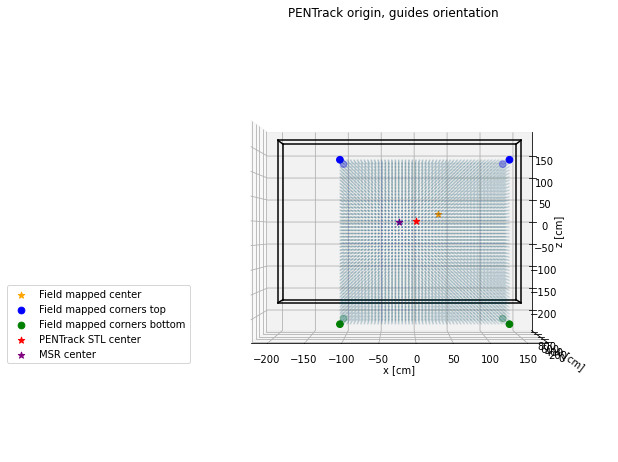

In [26]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d') 
data1 = [center_PEN_notRot, corners_PEN_notRot, data_PEN_notRot, MSR_center_PEN_notRot, O_PEN_notRot]

ctf.plotMapping(ax1, data1, title="PENTrack origin, guides orientation", view=1)

ax1.scatter(data_PEN_notRot['x'], data_PEN_notRot['y'], data_PEN_notRot['z'], s=1, alpha=0.01)
plt.show()

In [8]:
rotationAngle = -20 - 90 #20 degree switch from Y, plus swapping the x and y coords

O_PEN = O_PEN_notRot

center_PEN = ctf.rotate3D(center_PEN_notRot.T, origin=O_PEN_notRot, degrees=rotationAngle).T
corners_PEN = ctf.rotate3D(corners_PEN_notRot.T, origin=O_PEN_notRot, degrees=rotationAngle).T

data_PEN = ctf.rotateBData(data_PEN_notRot.copy(), O_PEN_notRot, rotationAngle)
# print(data_PEN)
# data_PEN[['x', 'y', 'z']] = rotate3D(data_PEN_notRot[['x', 'y', 'z']].values, origin=O_PEN_notRot, degrees=rotationAngle).T

MSR_center_PEN = ctf.rotate3D(MSR_center_PEN_notRot.T, origin=O_PEN_notRot, degrees=rotationAngle).T

       x      y       z       B_x      B_y       B_z
0 -106.6  323.8 -217.98 -1.522228 -0.07555 -0.675982
            x          y       z       B_x       B_y       B_z
0  340.731818 -10.574889 -217.98  0.449639  1.456266 -0.675982
-1.522227999999373 -0.0755495999991353


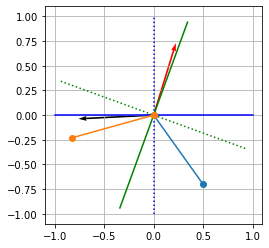

In [9]:
#trying to figure out if I've done the rotation properly
d1 = data_PEN_notRot.iloc[:1]
d2 = data_PEN.iloc[:1]

print(d1)
print(d2)

xline = np.linspace(-1, 1)
yline = np.linspace(-1, 1)

# print(d1['B_x']**2 + d1['B_y']**2 )
# print(d2['B_x']**2 + d2['B_y']**2 )

print(d1['B_x'][0], d1['B_y'][0])

# fig1, ax1 = plt.subplots()
# Q1 = ax1.quiver(d1['x'],d1['y'],d1['B_x'], d1['B_y'])
# Q2 = ax1.quiver(d2['x'],d2['y'],d2['B_x'], d2['B_y'])

plt.plot(xline, 0*xline, c='b')
plt.plot(yline*0, yline, c='b', ls=":")

x1, y1 = ctf.rotate(np.array([xline,  0*xline]).T, degrees=rotationAngle).T
plt.plot(x1, y1, c='g')
x2, y2 = ctf.rotate(np.array([yline*0, yline]).T, degrees=rotationAngle).T
plt.plot(x2, y2, c='g', ls=":")

p1 = np.array([[0, 0.5], [0, -0.7]])
plt.plot(p1[0], p1[1], marker="o")

p2 = ctf.rotate(p1.T, degrees=rotationAngle).T
plt.plot(p2[0], p2[1], marker="o")

Q1 = plt.quiver(0,0, d1['B_x'], d1['B_y'], units='x', scale =2)
Q2 = plt.quiver(0,0, d2['B_x'], d2['B_y'], units='x', scale =2, color='r')
plt.grid()
# plt.xlim(-0.)
# plt.ylim()
plt.gca().set_aspect("equal")

plt.show()

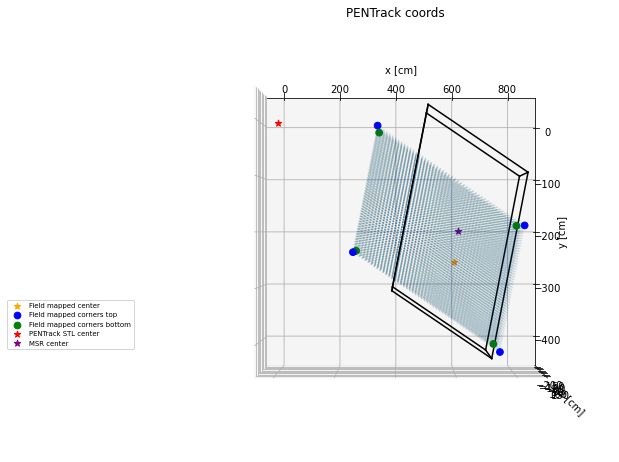

In [10]:
#rotated results
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d') 
data = [center_PEN, corners_PEN, data_PEN, MSR_center_PEN, O_PEN]
ctf.plotMapping(ax1, data, title="PENTrack coords", view=0, angle=rotationAngle)

ax1.scatter(data_PEN['x'], data_PEN['y'], data_PEN['z'], s=1, alpha=0.01)

plt.show()    

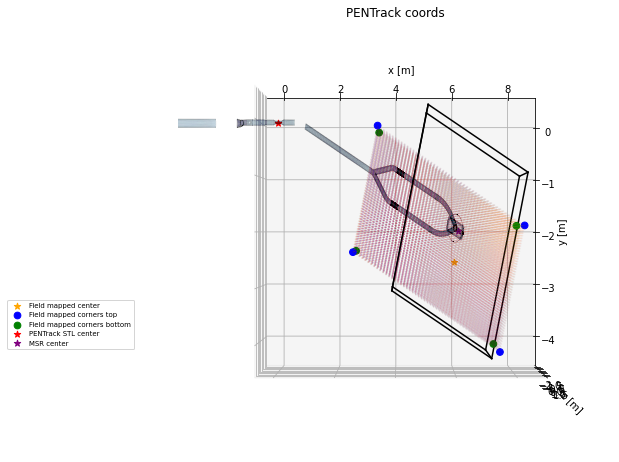

In [11]:
#converting to m to plot with STLs
center_PEN_m = center_PEN/100
corners_PEN_m = corners_PEN/100
MSR_center_PEN_m = MSR_center_PEN/100
data_PEN_m = data_PEN/100

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d') 
data2 = [center_PEN_m, corners_PEN_m, data_PEN_m, MSR_center_PEN_m, O_PEN]
ctf.plotMapping(ax1, data2, title="PENTrack coords", view=0, angle=rotationAngle, units="m", STLs=True)

Q = ax1.scatter(data_PEN_m['x'], data_PEN_m['y'], data_PEN_m['z'],c=data_PEN_m['B_x']*100, s=1, alpha=0.01, cmap=cm.plasma)
# cbar = fig.colorbar(Q, label='$\mathsf{B_z\,(\mu T)}$')

plt.show()    

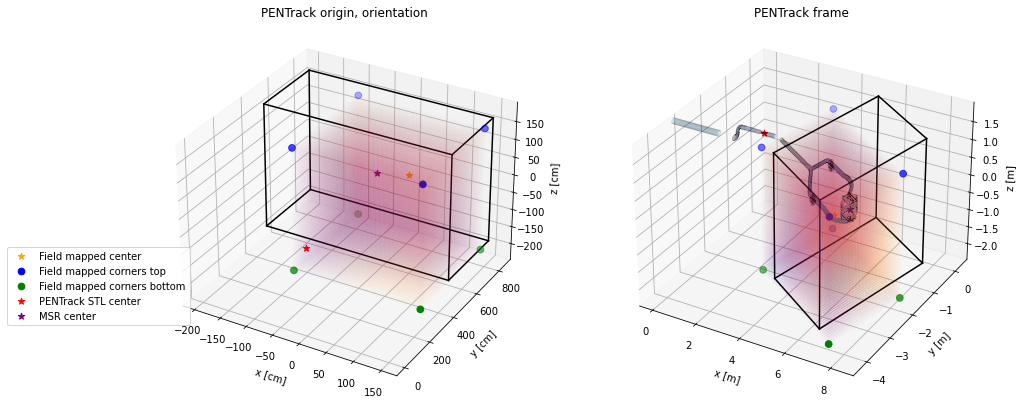

In [16]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ctf.plotMapping(ax1, data1, title="PENTrack origin, orientation", view=4)
Q = ax1.scatter(data1[2]['x'], data1[2]['y'], data1[2]['z'],c=data1[2]['B_x']*100, s=1, alpha=0.02, cmap=cm.plasma)

ctf.plotMapping(ax2, data2, title="PENTrack frame", view=4, angle=rotationAngle, units="m", STLs=True, legend=False)
Q = ax2.scatter(data2[2]['x'], data2[2]['y'], data2[2]['z'],c=data2[2]['B_x']*100, s=1, alpha=0.02, cmap=cm.plasma)

plt.show()  

## Reformating of B files for PENTrack

In [17]:
def FixOffset_1(df_BField_data):
   
    center_T = np.array([0, 0, 0]) #our intial origin
    data_T = df_BField_data[["x", "y", "z", "B_x", "B_y", "B_z"]] #original data

    #getting the correct shift to use in PENtrack, but not the coordinate rotation
    center_PEN_notRot, corners_PEN_notRot, data_PEN_notRot, MSR_center_PEN_notRot = ctf.refToPENTrack(data_T, center_T)

    off_sets = center_PEN_notRot #how much the old origin has shifted
    O_PEN_notRot =  np.array([0, 0, 0]) #the new origin to rotate about
    
    rotationAngle = -20 - 90 #20 degree switch from Y, plus swapping the x and y coords
    
    #apply the rotation to both the position and the B field components
    data_PEN = ctf.rotateBData(data_PEN_notRot.copy(), O_PEN_notRot, rotationAngle)
    center_PEN = ctf.rotate3D(center_PEN_notRot.T, origin=O_PEN_notRot, degrees=rotationAngle).T
    #     print(off_sets, MSR_center_PEN)

    #need to pad data to get a rectilinear grid
    
    
    return data_PEN, off_sets, rotationAngle, center_PEN

In [19]:
file = "data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv"

df_BField_data = pd.read_csv(file, comment='#')
df_BField_data_fixed, off_sets, rotation, off_setwithRotation = FixOffset_1(df_BField_data)
# display(df_BField_data_fixed)

BField_data_fixed = df_BField_data_fixed.to_numpy()
BField_Names = df_BField_data_fixed.columns
# BField_data_fixed

In [25]:
comment = "This data is interpolated from Takashi's summer 2019 data. Trying to position referenced properly,"+\
    " to match the origin and axes used in PENTrack STL files."

headerText = f'File: {file}\n' + f'Date created: {date.today().strftime("%d/%m/%Y")}\n'\
    + 'Units: [cm], [G = 1e-4 T]\n' +f'Offset from original data used: {off_sets} cm\n + \nRotation about z axis: '\
    + f'{rotation} degrees\n' + f'Resulting total origin shift: {off_setwithRotation} cm\n'\
    + f'Comments: {comment}\n' + '\t'.join(BField_Names)

print(headerText)

File: data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv
Date created: 12/08/2022
Units: [cm], [G = 1e-4 T]
Offset from original data used: [ 35.2  651.05  16.3 ] cm
 + 
Rotation about z axis: -110 degrees
Resulting total origin shift: [ 599.74777172 -255.74939456   16.3       ] cm
Comments: This data is interpolated from Takashi's summer 2019 data. Trying to position referenced properly, to match the origin and axes used in PENTrack STL files.
x	y	z	B_x	B_y	B_z


In [24]:
# df_BField_data_fixed.to_csv('./data_export/map_test.txt', sep='\t', header=headerText)
file_save = file.split("/")[-1].split("[")[0] + "referencedPENTrack"

np.savetxt(f'./data_export/{file_save}.txt', BField_data_fixed,  delimiter='\t', newline='\n', header=headerText)

In [ ]:
# M = np.meshgrid()

x,y,z = np.meshgrid( np.linspace(-2,2, 5), np.linspace(-3,3, 5), np.linspace(-1,1, 5))
# M = np.meshgrid( np.linspace(-2,2), np.linspace(-3,3), np.linspace(-1,1))

M = np.array([x.flatten(), y.flatten(), z.flatten()])
# print(M.shape)

df_test = pd.DataFrame(M.T, columns=['x', 'y', 'z'])
# display(df_test)
# df_test_rot = rotateBData(df_test.copy(), O_PEN_notRot, rotationAngle)
test_rot = rotate3D(df_test.values, degrees=30)
df_test_rot = pd.DataFrame(test_rot, columns=['x', 'y', 'z'])


MinMax = df_test_rot.apply(lambda x: [min(x), max(x)], axis=0).to_numpy()

n = 5
x,y,z = np.meshgrid( np.linspace(MinMax[0][0],MinMax[1][0], n), np.linspace(MinMax[0][1],MinMax[1][1], n), \
                    np.linspace(MinMax[0][2],MinMax[1][2], n))
M = np.array([x.flatten(), y.flatten(), z.flatten()])
# print(M.shape)

df_square = pd.DataFrame(M.T, columns=['x', 'y', 'z'])
#the problem is that this grid doesn't match up with the rotated one, which really won't ever be a grid like this

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d') 

ax1.scatter(df_test['x'], df_test['y'], df_test['z'], alpha=.8)
ax1.scatter(df_test_rot['x'], df_test_rot['y'], df_test_rot['z'], alpha=.4)
ax1.scatter(df_square['x'], df_square['y'], df_square['z'], alpha=.8)

ax1.view_init(elev=90., azim=-90)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_zlabel('z [m]')
plt.show()    